In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saeel's Link
df = pd.read_csv("/content/drive/MyDrive/DS203/EDA.csv")

In [ ]:
# Pranav's Link
# df = pd.read_csv("/content/drive/MyDrive/College/Project/EDA.csv")

In [ ]:
df.head()

,Unnamed: 0,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,OpenStatus,Tags_0,Tags_1,Tags_2,Tags_3,Tags_4,Tags_5,...,Tags_9,Tags_10,Tags_11,Tags_12,Tags_13,Tags_14,Tags_15,Tags_16,AccAge,Description
0,0,1,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,21009539.0,for mongodb is it better to reference an objec...
1,1,192,24,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,10547952.0,how to insert schemalocation in a xml document...
2,2,1,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1414.0,too many lookup tables what are the adverse e...
3,3,4,1,4,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,22373759.0,what is this php code in vb.net i am looking f...
4,4,334,14,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,39151167.0,spring-data mongodb querying multiple classes ...


Link to the dataset: https://drive.google.com/file/d/1L6yQXX1DntaIWhKMIviJnCoM2FIF8prM/view?usp=share_link

# **Normalizing and splitting our dataset for LSTM model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [ ]:
train_df, test_df = train_test_split(df, test_size= 0.4, shuffle= True, random_state= 42, stratify= df["OpenStatus"])

In [ ]:
train_desc_str = train_df[["Description"]]
train_other = train_df.drop(["OpenStatus", "Description"], axis= 1)
train_targ = train_df["OpenStatus"]

In [ ]:
test_desc_str = test_df[["Description"]]
test_other = test_df.drop(["OpenStatus", "Description"], axis= 1)
test_targ = test_df["OpenStatus"]

In [ ]:
scaler = RobustScaler()
train_other = scaler.fit_transform(train_other)
test_other = scaler.fit_transform(test_other)

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

# **Model Building**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

# **LSTM**

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
text_v = TextVectorization()
text_v.adapt(train_desc_str)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

Reference: 

*   https://analyticsindiamag.com/how-to-code-your-first-lstm-network-in-keras/
*   https://www.analyticsvidhya.com/blog/2022/01/the-complete-lstm-tutorial-with-implementation/



In [ ]:
max_num_of_tokens = 20000
max_length = 200
embedded_dim = 100
NUM_CLASSES = train_targ.nunique()
desc_vector = TextVectorization(max_tokens= max_num_of_tokens, output_sequence_length= max_length, name= "desc_vector")
desc_vector.adapt(train_desc_str)

text_input = layers.Input(shape= (1, ), dtype= tf.string, name= "text_input")
x = desc_vector(text_input)
x = layers.Embedding(input_dim= max_num_of_tokens, output_dim= embedded_dim, input_length= max_length, name= "embedding")(x)
x = layers.LSTM(units= 128, name= "hidden_lstm")(x)

input_other = layers.Input(shape= train_other.shape[1:], name= "input_other")
y = layers.Concatenate()([x, input_other])
y = layers.Dense(units= 256, activation= "selu", kernel_initializer= "lecun_normal", name= "hidder_dense_1")(y)
y = layers.BatchNormalization()(y)
y = layers.Dense(units= 64, activation= "softmax", name= "softmax_output")(y)
model = Model(inputs= [text_input, input_other], outputs= y, name= "NLP")

In [ ]:
model.compile(optimizer= "adam", loss= "sparse_categorical_crossentropy", metrics= ["accuracy"])
model.summary()

Model: "NLP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 desc_vector (TextVectorization  (None, 200)         0           ['text_input[0][0]']             
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 200, 100)     2000000     ['desc_vector[0][0]']            
                                                                                                  
 hidden_lstm (LSTM)             (None, 128)          117248      ['embedding[0][0]']            

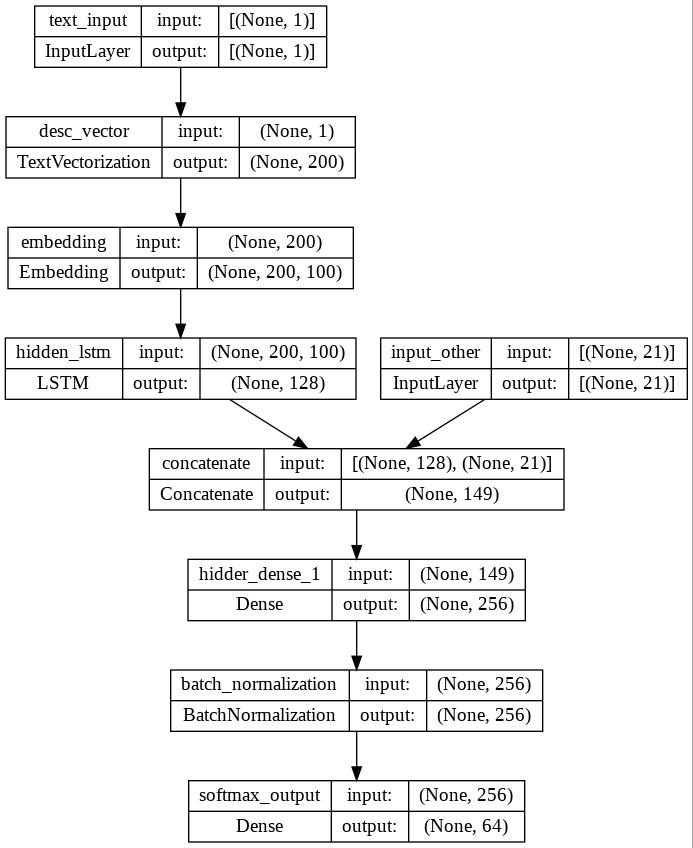

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model= model, to_file= "NLP_Model.jpeg", show_shapes= True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

red_learning_rate = ReduceLROnPlateau(monitor= "val_loss", factor= 0.3, patience= 7, verbose= True)
early_stop = EarlyStopping(monitor= "val_loss", patience= 35, restore_best_weights= True, verbose= True)
callbacks = [red_learning_rate, early_stop]

Reference: https://keras.io/api/callbacks/reduce_lr_on_plateau/

In [ ]:
history = model.fit(x = [train_desc_str, train_other], y= train_targ, batch_size= 256, epochs= 100, verbose= 1, 
                    callbacks= callbacks, validation_data= ([test_desc_str, test_other], test_targ), shuffle= True)

Epoch 1/100
329/329 [==============================] - 311s 938ms/step - loss: 1.9882 - accuracy: 0.4645 - val_loss: 2.0354 - val_accuracy: 0.2420 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - 307s 933ms/step - loss: 1.2399 - accuracy: 0.5257 - val_loss: 1.1424 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - 307s 934ms/step - loss: 1.0738 - accuracy: 0.5797 - val_loss: 1.0542 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 4/100
329/329 [==============================] - 306s 932ms/step - loss: 1.0019 - accuracy: 0.6083 - val_loss: 1.2727 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 5/100
329/329 [==============================] - 306s 931ms/step - loss: 0.9475 - accuracy: 0.6320 - val_loss: 1.0626 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 6/100
329/329 [==============================] - 307s 934ms/step - loss: 0.9050 - accuracy: 0.6493 - val_loss: 1.0983 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 7/100
329/329 [===================

In [ ]:
model.evaluate([test_desc_str, test_other], test_targ)

1754/1754 [==============================] - 114s 65ms/step - loss: 1.0542 - accuracy: 0.5910


[1.0541527271270752, 0.591010332107544]